In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np

np.arange(0.4, 0.9, 0.05)**2

array([0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
       0.64  , 0.7225])

In [3]:
import train.run_configs as run_configs

from tasks.arithmetic import ArithmeticTrainer
from dataclasses import asdict

c = run_configs.baseline

asdict(c)

{'model_class': models.transformer.Transformer,
 'model_partial': None,
 'model_params': {'d_model': 128,
  'd_mlp': 512,
  'n_vocab': 114,
  'max_seq_len': 3,
  'n_heads': 4,
  'n_layers': 1,
  'init_scale': 1.0,
  'use_ln': False},
 'n_epochs': 20000,
 'batch_size': 512,
 'get_optimizer': None,
 'learning_rate': 0.001,
 'weight_decay': 1.0,
 'criterion': CrossEntropyHighPrecision(),
 'accumulation_steps': 1,
 'data_config': {'p': 113, 'noise_frac': 0.0},
 'max_gpus': None,
 'checkpoints_base_dir': 'saved_models',
 'model_name': 'arithmetic_transformer',
 'checkpoint_dir': None,
 'n_evals': 128,
 'n_checkpoints': 32,
 'save_method': 'state_dict',
 'log': True,
 'experiment_group': None,
 'notes': None,
 'tags': None,
 'train_frac': 0.3}

: 

Number of samples: 3830


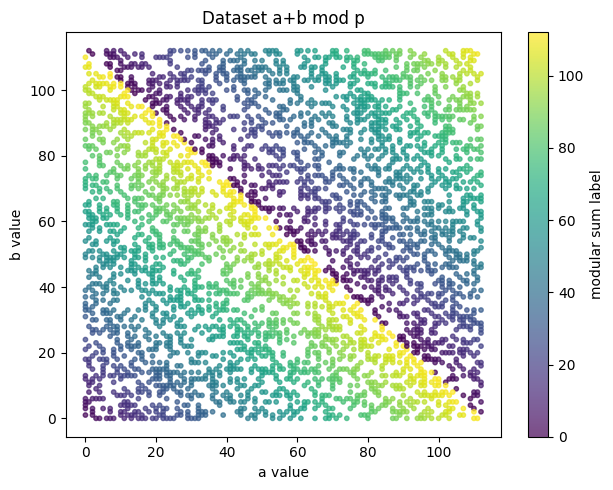

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from utils.config import MODELS_DIR
import os
from tasks.arithmetic import get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig, visualize_data
from models.transformer import Transformer

device = t.device("cuda" if t.cuda.is_available() else "cpu")

config = ArithmeticDatasetConfig(
  p=113,
  noise_frac=0
)

train_dataloader, val_dataloader, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, train_frac=0.3)
visualize_data(train_dataloader)
data_iter = iter(train_dataloader)

In [3]:
from tasks.arithmetic.dataset import ModArithmeticCpDataset

dataset = ModArithmeticCpDataset(config=ArithmeticDatasetConfig())

train_frac = 0.3
val_frac = 0

assert train_frac + val_frac <= 1, f"train_frac {train_frac} + val_frac {val_frac} must be < 1"

train_size = int(len(dataset) * train_frac)
val_size = int(len(dataset) * val_frac)
rest = len(dataset) - train_size - val_size


train_dataset, val_dataset, _ = t.utils.data.random_split(
  dataset,
  [train_size, val_size, rest],
  generator=t.Generator().manual_seed(42) # for reproducibility
)

val_dataloader = t.utils.data.DataLoader(
  val_dataset,
  batch_size=256,
  shuffle=False,
  drop_last=False,
)


print(f"train size: {len(train_dataset)}, val size: {len(val_dataset)}")

train size: 3830, val size: 0


In [8]:
from tasks.arithmetic.checkpoints import load_model_checkpoint

checkpoint_dir = os.path.join(MODELS_DIR, 'arithmetic_transformer/baseline')

cp = load_model_checkpoint(Transformer, checkpoint_dir, checkpoint=None, device=device)

data_iter = iter(cp.dataloader)
cp.val_loss

6.2727969109306e-08

/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


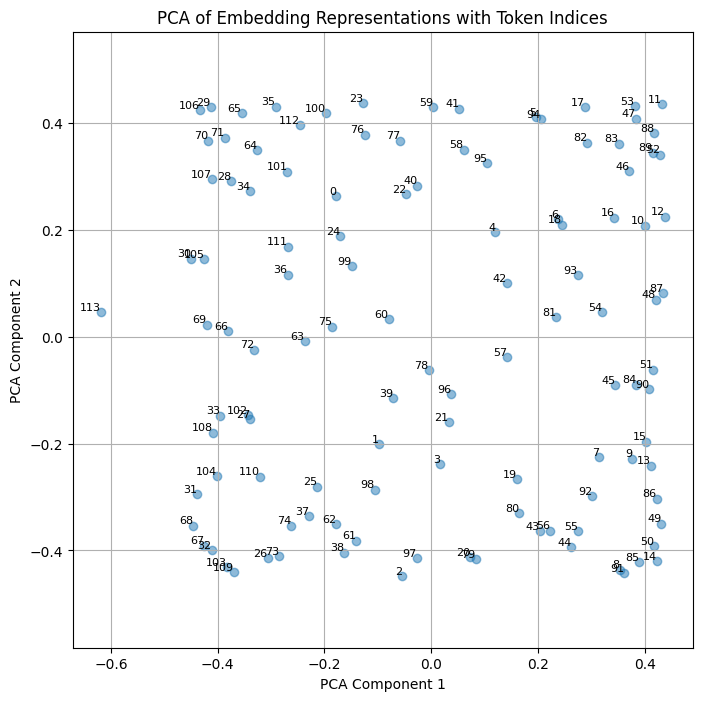

/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


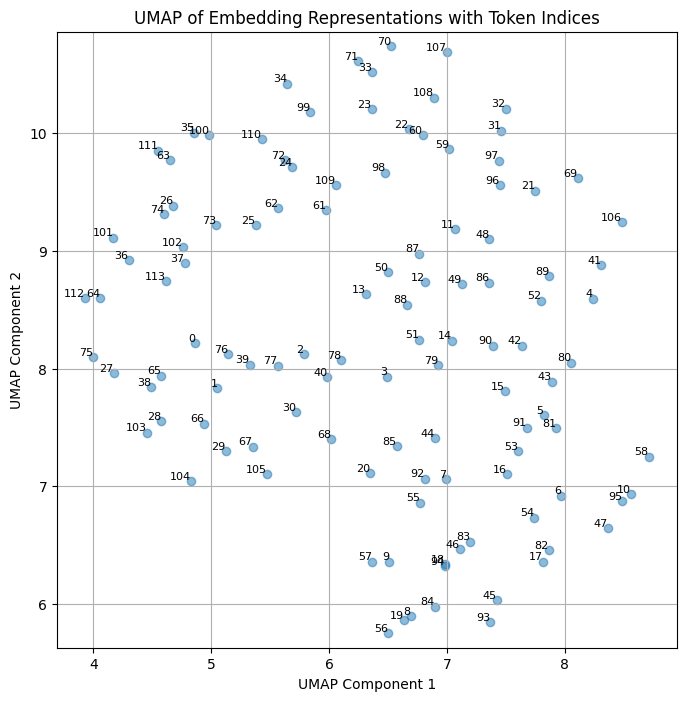

In [18]:
from models.other import MLP, MLPWithEmbedding
from models.transformer import Transformer
from models.transformer import Embedding
from utils.helpers import CrossEntropyHighPrecision
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP

representations = cp.model.embedding.W_embed

integers = t.arange(0, config.p, device=device).unsqueeze(1)  # Shape (p, 1)

# Plot PCA of representations with labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(representations.T.cpu().detach().numpy()) 
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)

# Add labels to each point
for i, (x, y) in enumerate(X_pca):
  plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

plt.title('PCA of Embedding Representations with Token Indices')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [35]:
from torchinfo import summary

summary(cp.model, input_size=(256, 3), dtypes=[t.long], device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [256, 114]                --
├─Embedding: 1-1                         [256, 3, 128]             14,592
├─PosEmbedding: 1-2                      [256, 3, 128]             384
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-1             [256, 3, 128]             --
│    │    └─Attention: 3-1               [256, 3, 128]             65,536
│    │    └─MLP: 3-2                     [256, 3, 128]             131,712
├─Unembed: 1-4                           [256, 3, 114]             14,592
Total params: 226,816
Trainable params: 226,816
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 33.72
Input size (MB): 0.01
Forward/backward pass size (MB): 6.99
Params size (MB): 0.91
Estimated Total Size (MB): 7.91